## Goal: What % of novel ICs in this experiment are not found in hg38? 
This will be helpful to contextualize the other findings

In [31]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [32]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [33]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

In [34]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel ics and count per cell line
temp = df.loc[df.structural_category!='full-splice_match']

# get only the detection from mapping
temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1.75. get those that are detected  in hap1/2 
temp = temp.loc[(temp.hap1+temp.hap2)>0]
temp['n_novel_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')


# 1. get those that are detected uniquely in hap1/2 
# (ie those not in hg38)
temp = temp.loc[(temp.hg38==False)&
                ((temp.hap1+temp.hap2)>0)]

# get total unique per cell line 
temp['n_non_hg38_novel_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')

temp = temp[['cell_line_id', 'n_novel_ic', 'n_non_hg38_novel_ic']].drop_duplicates()
assert len(temp.index) == len(temp.cell_line_id.unique())


<AxesSubplot:ylabel='perc_uniq_to_haplotypes'>

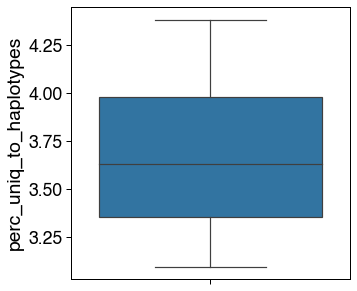

In [35]:
init_plot_settings(aspect='square')
temp['perc_uniq_to_haplotypes'] = (temp['n_non_hg38_novel_ic']/temp['n_novel_ic'])*100
sns.boxplot(temp, 
            y='perc_uniq_to_haplotypes')

In [45]:
temp.perc_uniq_to_haplotypes.median()

3.629005848039605

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


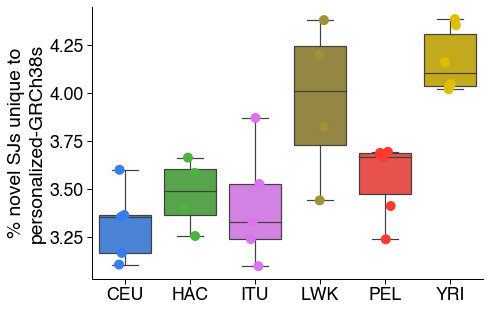

In [36]:
# do the plot by population too just because
temp = temp.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(cats=temp.population.unique().tolist())
ax = sns.boxplot(temp,
            x='population',
            y='perc_uniq_to_haplotypes',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='perc_uniq_to_haplotypes', data=temp, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='% novel SJs unique to\npersonalized-GRCh38s')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Are these differences correlated at all to seq. depth?

In [40]:
temp = temp.merge(meta_df[['cell_line_id_1000g', 'map_reads_assemblymap']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

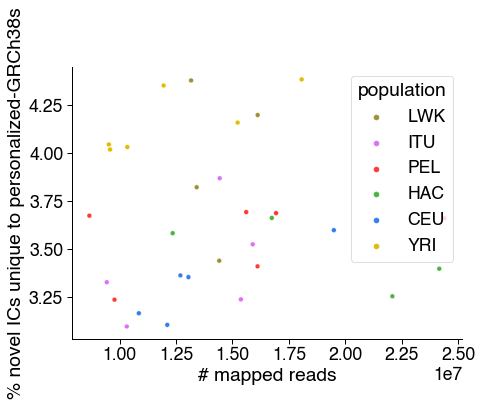

In [41]:
ax = sns.scatterplot(temp, y='perc_uniq_to_haplotypes', x='map_reads_assemblymap',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='% novel ICs unique to personalized-GRCh38s',
       xlabel='# mapped reads')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [42]:
x = temp.perc_uniq_to_haplotypes.tolist()
y = temp.map_reads_assemblymap.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)

-0.017580889324411292
0.9265314136744423

0.10656284760845385
0.5751604749636792


[Text(0.5, 15.700000000000003, 'Population 2'),
 Text(33.7, 0.5, 'Popluation 1'),
 Text(0.5, 1.0, 'Population differences in % of novel ICs\nunique to personalized-GRCh38s')]

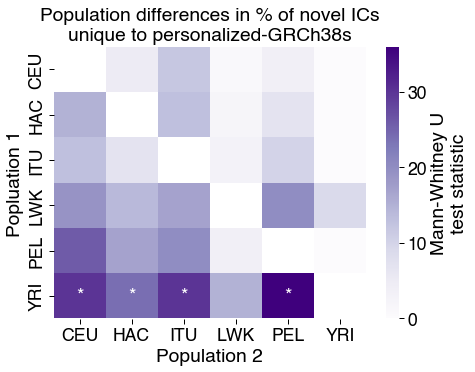

In [43]:
# test -- Mann-Whitney U for each pop. pair with hypothesis greater
import itertools

stat_df = pd.DataFrame()
for p1, p2 in list(itertools.permutations(temp.population.unique(), 2)):
    x = temp.loc[temp.population==p1,'perc_uniq_to_haplotypes'].tolist() # hyp. --> greater
    y = temp.loc[temp.population==p2,'perc_uniq_to_haplotypes'].tolist()
    
    try:
        stat, pval = st.mannwhitneyu(x, y, alternative='greater')
    except:
        break
    temp3 = pd.DataFrame(data=[[p1, p2, stat, pval]], 
                         columns=['pop1', 'pop2', 'stat', 'pval'])
    stat_df = pd.concat([stat_df, temp3], axis=0)
    del temp3
    
# fdr correction
from statsmodels.stats.multitest import multipletests
_, adj_p_vals, _, _ = multipletests(stat_df.pval.tolist(), method='fdr_bh')
stat_df['adj_pval'] = adj_p_vals
stat_df.head()

# add sig. annotation
# * <= 0.05
# ** <= 0.01
# *** <= 0.001
stat_df['sig_annot'] = ''
# stat_df.loc[stat_df.pval <= 0.05, 'sig_annot'] = '*'
# stat_df.loc[stat_df.pval <= 0.01, 'sig_annot'] = '**'
# stat_df.loc[stat_df.pval <= 0.001, 'sig_annot'] = '***'
stat_df.loc[stat_df.adj_pval <= 0.05, 'sig_annot'] = '*'
stat_df.loc[stat_df.adj_pval <= 0.01, 'sig_annot'] = '**'
stat_df.loc[stat_df.adj_pval <= 0.001, 'sig_annot'] = '***'

# pivot x2 to get a stat and annot df to plot
stat_df1 = stat_df.pivot(index='pop1', columns='pop2', values='stat')
annot_df = stat_df.pivot(index='pop1', columns='pop2', values='sig_annot')

ax = sns.heatmap(stat_df1, cmap='Purples',
            annot=annot_df,
            fmt='',
            cbar_kws={'label': 'Mann-Whitney U\ntest statistic'})

# labels need them
ax.set(xlabel='Population 2',
       ylabel='Popluation 1',
       title='Population differences in % of novel ICs\nunique to personalized-GRCh38s')

## Considering haplotypes separately

In [19]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel ics and count per cell line
temp = df.loc[df.structural_category!='full-splice_match']

# get only the detection from mapping
temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)
temp_back = temp.copy(deep=True)

big_df = pd.DataFrame()
for hap in ['hap1', 'hap2']:
    temp = temp_back.copy(deep=True)

    # 1.75. get those that are detected in this hap
    temp = temp.loc[temp[hap]==True]
    temp['n_novel_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')


    # 1. get those that are detected uniquely in hap1/2 
    # (ie those not in hg38)
    temp = temp.loc[(temp.hg38==False)&
                    (temp[hap]==True)]

    # get total unique per cell line 
    temp['n_non_hg38_novel_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')
    temp2 = temp[['n_non_hg38_novel_ic', 'cell_line_id']].drop_duplicates()
    # assert temp2.n_non_hg38_novel_sj.median() == 465

    temp = temp[['cell_line_id', 'n_novel_ic', 'n_non_hg38_novel_ic']].drop_duplicates()
    assert len(temp.index) == len(temp.cell_line_id.unique())
    temp['hap'] = hap
    big_df = pd.concat([big_df, temp], axis=0)

In [20]:
big_df.loc[big_df.cell_line_id=='HG02261']

,cell_line_id,n_novel_ic,n_non_hg38_novel_ic,hap
550,HG02261,25980,779,hap1
611,HG02261,26008,788,hap2


<AxesSubplot:ylabel='perc_uniq_to_haplotypes'>

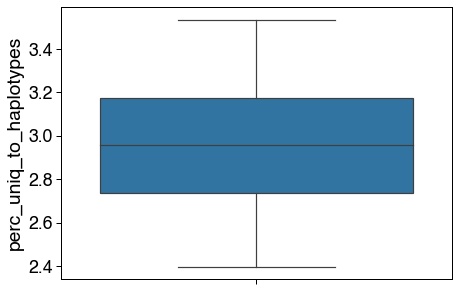

In [21]:
init_plot_settings(aspect='rectangle')
big_df['perc_uniq_to_haplotypes'] = (big_df['n_non_hg38_novel_ic']/big_df['n_novel_ic'])*100
sns.boxplot(big_df, 
            y='perc_uniq_to_haplotypes')

In [22]:
big_df.perc_uniq_to_haplotypes.median()

2.9574014925217096

In [23]:
big_df = big_df.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  app.launch_new_instance()


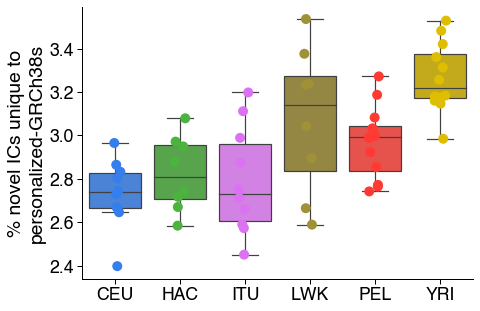

In [25]:
# do the plot by population too just because

init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(big_df.population.unique().tolist())
ax = sns.boxplot(big_df,
            x='population',
            y='perc_uniq_to_haplotypes',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='perc_uniq_to_haplotypes', data=big_df, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='% novel ICs unique to\npersonalized-GRCh38s')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Are these differences correlated at all to seq. depth?

In [37]:
big_df = big_df.merge(meta_df[['cell_line_id_1000g', 'map_reads_assemblymap']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

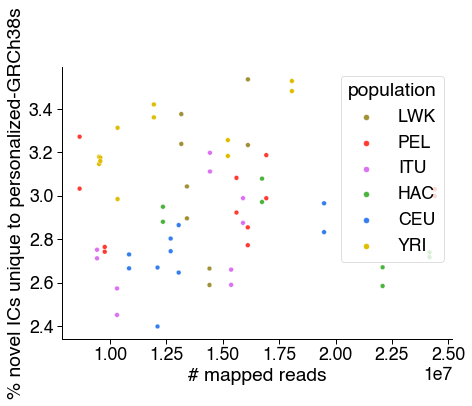

In [27]:
ax = sns.scatterplot(big_df, y='perc_uniq_to_haplotypes', x='map_reads_assemblymap',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='% novel ICs unique to personalized-GRCh38s',
       xlabel='# mapped reads')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [28]:
x = big_df.perc_uniq_to_haplotypes.tolist()
y = big_df.map_reads_assemblymap.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)

-0.016947316019623793
0.8977366348031711

0.044141768951741336
0.7377070662580315


[Text(0.5, 15.700000000000003, 'Population 2'),
 Text(33.7, 0.5, 'Popluation 1'),
 Text(0.5, 1.0, 'Population differences in % of novel ICs\nunique to personalized-GRCh38s')]

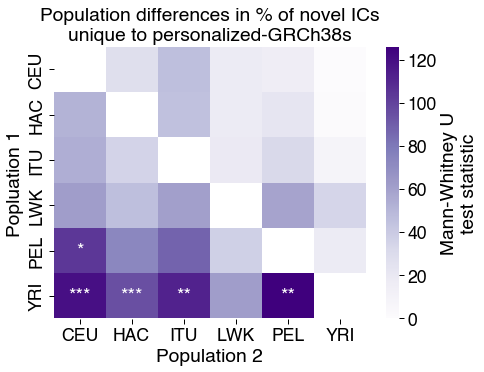

In [30]:
# test -- Mann-Whitney U for each pop. pair with hypothesis greater
import itertools

stat_df = pd.DataFrame()
for p1, p2 in list(itertools.permutations(big_df.population.unique(), 2)):
    x = big_df.loc[big_df.population==p1,'perc_uniq_to_haplotypes'].tolist() # hyp. --> greater
    y = big_df.loc[big_df.population==p2,'perc_uniq_to_haplotypes'].tolist()
    
    try:
        stat, pval = st.mannwhitneyu(x, y, alternative='greater')
    except:
        break
    temp3 = pd.DataFrame(data=[[p1, p2, stat, pval]], 
                         columns=['pop1', 'pop2', 'stat', 'pval'])
    stat_df = pd.concat([stat_df, temp3], axis=0)
    del temp3
    
# fdr correction
from statsmodels.stats.multitest import multipletests
_, adj_p_vals, _, _ = multipletests(stat_df.pval.tolist(), method='fdr_bh')
stat_df['adj_pval'] = adj_p_vals
stat_df.head()

# add sig. annotation
# * <= 0.05
# ** <= 0.01
# *** <= 0.001
stat_df['sig_annot'] = ''
# stat_df.loc[stat_df.pval <= 0.05, 'sig_annot'] = '*'
# stat_df.loc[stat_df.pval <= 0.01, 'sig_annot'] = '**'
# stat_df.loc[stat_df.pval <= 0.001, 'sig_annot'] = '***'
stat_df.loc[stat_df.adj_pval <= 0.05, 'sig_annot'] = '*'
stat_df.loc[stat_df.adj_pval <= 0.01, 'sig_annot'] = '**'
stat_df.loc[stat_df.adj_pval <= 0.001, 'sig_annot'] = '***'

# pivot x2 to get a stat and annot df to plot
stat_df1 = stat_df.pivot(index='pop1', columns='pop2', values='stat')
annot_df = stat_df.pivot(index='pop1', columns='pop2', values='sig_annot')

ax = sns.heatmap(stat_df1, cmap='Purples',
            annot=annot_df,
            fmt='',
            cbar_kws={'label': 'Mann-Whitney U\ntest statistic'})

# labels need them
ax.set(xlabel='Population 2',
       ylabel='Popluation 1',
       title='Population differences in % of novel ICs\nunique to personalized-GRCh38s')